In [53]:
%matplotlib inline
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

from torchsummary import summary

device = torch.device('cuda:1')

In [54]:
# fileid: 12XWUcct4LA_bZXaccScYUBC97S9R90L1
# filename: crop_part1.tar.gz
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XWUcct4LA_bZXaccScYUBC97S9R90L1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XWUcct4LA_bZXaccScYUBC97S9R90L1" -O crop_part1.tar.gz && rm -rf ~/cookies.txt
!tar -zxvf crop_part1.tar.gz

--2022-06-14 05:50:17--  https://docs.google.com/uc?export=download&confirm=t&id=12XWUcct4LA_bZXaccScYUBC97S9R90L1
Resolving docs.google.com (docs.google.com)... 216.58.220.142, 2404:6800:4004:813::200e
Connecting to docs.google.com (docs.google.com)|216.58.220.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t40s0p7ea25l8mht3t34e36eicmlhqsc/1655185800000/16525786242263481678/*/12XWUcct4LA_bZXaccScYUBC97S9R90L1?e=download [following]
--2022-06-14 05:50:18--  https://doc-14-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t40s0p7ea25l8mht3t34e36eicmlhqsc/1655185800000/16525786242263481678/*/12XWUcct4LA_bZXaccScYUBC97S9R90L1?e=download
Resolving doc-14-1k-docs.googleusercontent.com (doc-14-1k-docs.googleusercontent.com)... 172.217.31.129, 2404:6800:4004:808::2001
Connecting to doc-14-1k-docs.googleusercontent.com (doc-14-1k-docs.goo

In [55]:
tmp = os.listdir('./crop_part1')
print(len(tmp))
print(tmp[0])

9781
25_1_3_20170104222459455.jpg.chip.jpg


In [56]:
fname = '1_1_0_20161219204750596.jpg.chip.jpg'
splits = fname.split('_')
print(splits)

['1', '1', '0', '20161219204750596.jpg.chip.jpg']


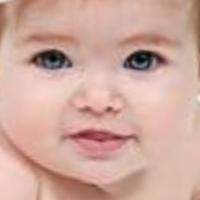

In [57]:
img = Image.open(
    './crop_part1/1_1_0_20161219204750596.jpg.chip.jpg').convert('RGB')
img

In [58]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform):
        # implement this.
        # 필요한 정보들 생성.
        # Hint: os.listdir(directory) -> List[filename]
        self.root_dir = root_dir
        self.filenames = os.listdir(root_dir)
        self.transform = transform
        
    def __len__(self):
        # implement this.
        # 데이터 셋의 크기가 얼마인지? (또는, image가 몇장 있는지)
        return len(self.filenames)
        
    def __getitem__(self, idx):
        # implement this
        # 인덱스 (idx)를 받아서, 해당 idx 의 data 와 label 을 반환.
        # Hint: Image.open(filename).convert('RGB')
        # Hint: '1' -> 1. 로 바꾸기 위해선 float() 을 사용.
        # Hint: filename = {age}_{gender}_{race}_{time}.jpg
        filename = self.filenames[idx]
        splits = filename.split('_')
        age = float(splits[0])
        gender = float(splits[1])
        race = float(splits[2])
        img = Image.open(os.path.join(self.root_dir, filename)).convert('RGB')
        img = self.transform(img)
        return {
            "image": img, # [3, 224, 224]
            "age": age,
            "gender": gender,
            "race": race,
            "filename": filename
        }

In [59]:
##implement dataset and dataloader
dataset = FaceDataset("./crop_part1", transform)
train_length = int(len(dataset) * 0.9)
test_length = len(dataset) - train_length
train_set, test_set = torch.utils.data.random_split(dataset, [train_length, test_length])
print(len(train_set), len(test_set))

8802 979


In [60]:
def my_collate_fn(list_data):
#     [dataset.__getitem__(0), ..., dataset.__getitem__(7)]
    data_dicts = {
        "image": [],
        "age": [],
        "gender": [],
        "race": [],
        "filename": []
    }
    batch_size = len(list_data)
    for i in range(batch_size):
        data = list_data[i] # {"image": torch.Tensor, "age": float, "filename": str}
        data_dicts["image"].append(data["image"].unsqueeze(0)) # [1, 3, 224, 224]
        data_dicts["age"].append(data["age"])
        data_dicts["gender"].append(data["gender"])
        data_dicts["race"].append(data["race"])
        data_dicts["filename"].append(data["filename"])
    data_dicts["image"] = torch.cat(data_dicts["image"], dim=0)
    data_dicts["age"] = torch.tensor(data_dicts["age"])
    data_dicts["gender"] = torch.tensor(data_dicts["gender"])
    data_dicts["race"] = torch.tensor(data_dicts["race"])
    return data_dicts

In [61]:
batch_size = 8
trainloader = DataLoader(
    train_set, batch_size = batch_size, shuffle = True, collate_fn=my_collate_fn
)
testloader = DataLoader(
    test_set, batch_size = batch_size, shuffle = False, collate_fn=my_collate_fn
)

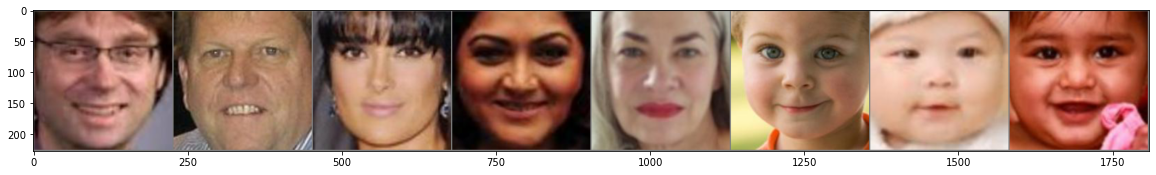

Age :   40.0  53.0  26.0  39.0  80.0   2.0   1.0   1.0
Gender :    0.0   0.0   1.0   1.0   1.0   0.0   0.0   1.0
Race :    0.0   0.0   4.0   3.0   0.0   0.0   2.0   3.0


In [62]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormdealize
    npimg = img.numpy()
    plt.figure(figsize=(20,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
data_dicts = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(data_dicts["image"]))

# print labels
print('Age : ', ' '.join('%5s' % str(data_dicts["age"][j].item()) for j in range(8)))
print('Gender : ', ' '.join('%5s' % str(data_dicts["gender"][j].item()) for j in range(8)))
print('Race : ',' '.join('%5s' % str(data_dicts["race"][j].item()) for j in range(8)))

In [63]:
data_dicts['age'].shape

torch.Size([8])

In [64]:
# ResNet18 pretrained network 받아서 씀
class Net(nn.Module):
    def __init__(self, use_pretrained=True):
        super(Net, self).__init__()
        ##implement this
        # [3, 224, 224]
        self.net = models.resnet18(pretrained = use_pretrained) #fc layer 3 는 빼고 가져옴
        in_features = self.net.fc.in_features
        self.net.fc = nn.Linear(in_features, 1) #512, 1
        
    def forward(self, x):
        ##implement this
        return self.net(x)

In [65]:
net = models.vgg16()
print(net.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [66]:
#implement criterion
criterion = nn.MSELoss()

model = Net(use_pretrained=True)
summary(model, batch_size=-1, input_size=(3, 224, 224), device='cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [67]:
def train(epoch):
    model.train()
    total_loss = 0.
    for batch_idx, data_dict in enumerate(trainloader):
        target = data_dict["age"].type(torch.float).view(-1, 1)
#         target = target.type(torch.float).view(-1,1)
        data = data_dict["image"].to(device)
        target = target.to(device)
#         data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), total_loss/(batch_idx+1)))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data_dict in testloader:
        target = data_dict["age"].type(torch.float).view(-1,1)
        data, target = data_dict["image"].to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss

    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}'.format(
        test_loss, correct, len(testloader.dataset)))

In [68]:
for epoch in range(5):
    train(epoch)
    test()

Train Epoch: 0 [0/8802 (0%)]	Loss: 1250.361816
Train Epoch: 0 [80/8802 (1%)]	Loss: 1525.650801
Train Epoch: 0 [160/8802 (2%)]	Loss: 1326.865583
Train Epoch: 0 [240/8802 (3%)]	Loss: 1366.722467
Train Epoch: 0 [320/8802 (4%)]	Loss: 1306.566067
Train Epoch: 0 [400/8802 (5%)]	Loss: 1310.792324
Train Epoch: 0 [480/8802 (5%)]	Loss: 1197.556634
Train Epoch: 0 [560/8802 (6%)]	Loss: 1170.632727
Train Epoch: 0 [640/8802 (7%)]	Loss: 1118.398179
Train Epoch: 0 [720/8802 (8%)]	Loss: 1094.986551
Train Epoch: 0 [800/8802 (9%)]	Loss: 1058.173051
Train Epoch: 0 [880/8802 (10%)]	Loss: 1015.459994
Train Epoch: 0 [960/8802 (11%)]	Loss: 996.101509
Train Epoch: 0 [1040/8802 (12%)]	Loss: 979.593138
Train Epoch: 0 [1120/8802 (13%)]	Loss: 985.055477
Train Epoch: 0 [1200/8802 (14%)]	Loss: 954.260285
Train Epoch: 0 [1280/8802 (15%)]	Loss: 924.740174
Train Epoch: 0 [1360/8802 (15%)]	Loss: 901.635043
Train Epoch: 0 [1440/8802 (16%)]	Loss: 894.981532
Train Epoch: 0 [1520/8802 (17%)]	Loss: 884.043816
Train Epoch: 0 

ValueError: could not convert string to float: '.ipynb'

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % labels[j].item() for j in range(8)))

In [ ]:
images = images.to(device)
outputs = model(images)

outputs = outputs.squeeze()

print('Predicted: ', ' '.join('%.1f' % outputs[j].item() for j in range(8))) 